In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-24 16:40:55.923564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 16:40:56.080692: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 16:40:56.116376: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-24 16:40:56.780602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import numpy as np
import string

FULL_VOCAB = string.ascii_lowercase
SEQ_LEN = 100

def dataset1(vocab_size=2, dataset_size=10000, seq_len=10, full_vocab=FULL_VOCAB):
  """
  Inserts a space after a the first character in the vocabulary (and nowhere else)
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.where(inputs == vocab[0], 1., 0.).astype(np.float32)  # 1 = space, 0 = no space
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

def dataset2(vocab_size=2, dataset_size=10000, seq_len=10, full_vocab=FULL_VOCAB):
  """
  Inserts a space after the combination of 1st->2nd character in the vocabulary (and nowhere else)
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.ones_like(inputs, dtype=np.float32)
  for i, example in enumerate(inputs):
    previous_char = example[0]
    for j, char in enumerate(example[1:]):
      if (previous_char == vocab[0]) and (char == vocab[1]):  # 1 = space, 0 = no space
        outputs[i, j+1] = 2.
      previous_char = char
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

def dataset3(vocab_size=2, dataset_size=10000, seq_len=10, insert_space_every=3, full_vocab=FULL_VOCAB):
  """
  Inserts a space after a certain number of characters, no matter what the characters
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.zeros_like(inputs, dtype=np.float32)
  outputs[:, np.arange(insert_space_every-1, outputs.shape[1], insert_space_every)] = 1.
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

In [3]:
DATASET_FN = dataset2

def compatability_with_encoder(inputs, outputs):
    return (inputs, None), outputs

train_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
valid_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
test_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
train_ds.element_spec

2023-02-24 16:40:58.519563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 16:40:59.174624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(100,), dtype=tf.float32, name=None))

In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x))
tokenizer.get_vocabulary()

['', '[UNK]', 'b', 'a']

In [5]:
tokenizer("ababab")

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([3, 2, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [6]:
from segmentation.model import Encoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Encoder(
        num_layers=2,
        d_model=32,
        num_attention_heads=2,
        dff=32,
        seq_len=100,
        tokenizer=tokenizer
    ),
    Dense(3, activation="softmax")
])

In [7]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0), # Why can I not ignore class 0?
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [8]:
batched_train = train_ds.shuffle(100).batch(8)
batched_val = valid_ds.batch(8)

model.fit(batched_train, validation_data=batched_val, epochs=10)

Epoch 1/10
  10/1250 [..............................] - ETA: 23s - loss: 0.6906 - sparse_categorical_accuracy: 0.6952 - space_precision: 0.3087 - space_recall: 0.1369 - space_f1: 0.1896 - char_precision: 0.7643 - char_recall: 0.8754 - char_f1: 0.8161  

2023-02-24 16:41:06.641067: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 44s 31ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.7674 - space_precision: 0.5317 - space_recall: 0.5026 - space_f1: 0.5167 - char_precision: 0.8396 - char_recall: 0.8544 - char_f1: 0.8469 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.8248 - val_space_precision: 0.6448 - val_space_recall: 0.6530 - val_space_f1: 0.6489 - val_char_precision: 0.8851 - val_char_recall: 0.8814 - val_char_f1: 0.8833
Epoch 2/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9576 - space_precision: 0.9117 - space_recall: 0.9175 - space_f1: 0.9146 - char_precision: 0.9728 - char_recall: 0.9708 - char_f1: 0.9718 - val_loss: 0.0021 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 1.0000 - val_char_recall: 1.0000 - val_char_f1: 1.0000
Epoch 3/10
1250/1250 [==============================] - 38s 31m

In [9]:
model.evaluate(batched_val)

1250/1250 [==============================] - 15s 12ms/step - loss: 3.7694e-04 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 1.0000 - char_recall: 1.0000 - char_f1: 1.0000


[0.0003769432660192251, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [16]:
test_inputs = tf.constant(
    ("5554445".replace("4","a").replace("5","b"), 
     "55544455554445".replace("4","a").replace("5","b"), 
     "5454545454545454".replace("4","a").replace("5","b")))
preds = model(test_inputs)
truth = tf.ragged.constant([[1,1,1,1,1,1,2], [1,1,1,1,1,1,2,1,1,1,1,1,1,2], [1,1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1]])
char_conditional = (truth == 1).to_tensor(False, shape=(truth.shape[0],100))
space_conditional = (truth == 2).to_tensor(False, shape=(truth.shape[0],100))

In [17]:
tf.argmax(preds, axis=-1), preds

(<tf.Tensor: shape=(3, 100), dtype=int64, numpy=
 array([[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

Text(0.5, 0.98, 'Probabilities of space/char conditional on character input')

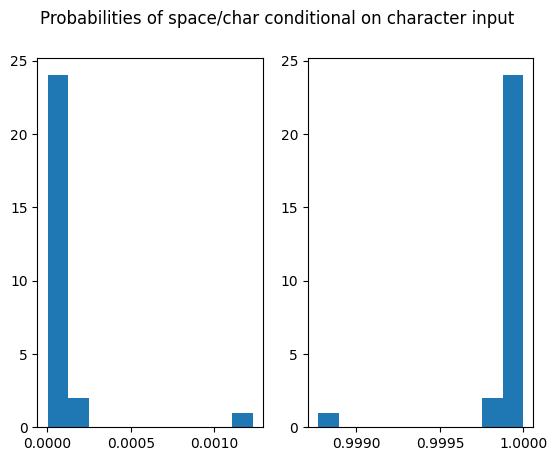

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
prob_of_space = preds[char_conditional][...,2]
prob_of_char = preds[char_conditional][...,1]
axs[0].hist(prob_of_space)
# axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on character input")

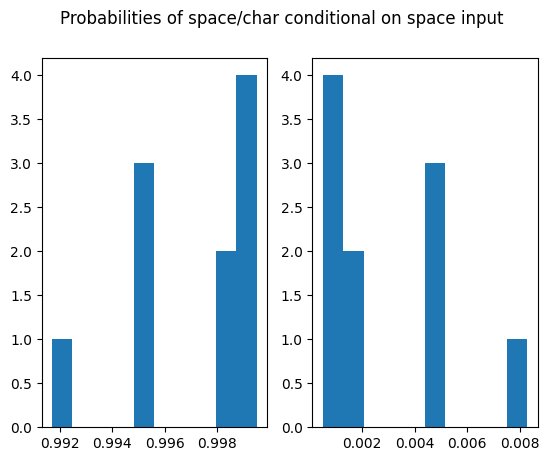

In [19]:
fig, axs = plt.subplots(1,2)
prob_of_space = preds[space_conditional][...,2]
prob_of_char = preds[space_conditional][...,1]
axs[0].hist(prob_of_space)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on space input")

fig.show()

In [23]:
test_inputs

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bbbaaab', b'bbbaaabbbbaaab', b'babababababababa'], dtype=object)>

In [25]:
tf.strings.length(test_inputs).numpy(), preds._keras_mask.numpy().sum(axis=1)

(array([ 7, 14, 16], dtype=int32), array([ 7, 14, 16]))

In [35]:
pos = model.layers[-2].pos_embedding.pos_encoding.numpy()
d_model = pos.shape[-1]
learned_embed = model.layers[-2].pos_embedding.embedding.embeddings.numpy()*(d_model**0.5)
tf.reduce_sum(pos@pos.T,axis=-1), tf.reduce_sum(learned_embed@learned_embed.T,axis=-1), d_model

(<tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([812.6395 , 819.95605, 827.36066, 834.3532 , 840.8653 , 847.2329 ,
        853.8167 , 860.62775, 867.3082 , 873.4756 , 879.09906, 884.5442 ,
        890.229  , 896.1991 , 902.0156 , 907.06995, 911.0549 , 914.1786 ,
        916.93994, 919.6775 , 922.3031 , 924.4524 , 925.89417, 926.8076 ,
        927.6577 , 928.7843 , 930.08655, 931.10815, 931.4602 , 931.20447,
        930.8489 , 930.95544, 931.70544, 932.8044 , 933.79785, 934.49475,
        935.1096 , 936.00116, 937.26514, 938.5756 , 939.43823, 939.6321 ,
        939.43384, 939.4076 , 939.93616, 940.90784, 941.8328 , 942.276  ,
        942.2151 , 942.00616, 942.00616, 942.2151 , 942.276  , 941.8328 ,
        940.9079 , 939.93616, 939.4076 , 939.43384, 939.6321 , 939.43823,
        938.5757 , 937.26514, 936.0012 , 935.1096 , 934.49475, 933.79785,
        932.8044 , 931.7053 , 930.95544, 930.8489 , 931.20447, 931.4602 ,
        931.10815, 930.0865 , 928.7843 , 927.6577 , 926.80756, 